# Eigenface

In [15]:
# Some general setup
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from data_utils import load_image

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (11.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Load path of dataset
dataset_path = 'dataset/'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_neutral, X_smile
    del original_size
    print('Clear previously loaded data.')
except:
    pass

# Function from data_utils.py
X_neutral, X_smile, original_size = load_image(dataset_path)

# Check and print out the size of the training data
print('Training data of neutral: ', X_neutral.shape)
print('Training data of smiling: ', X_smile.shape)
print('Original size of image: ', original_size)
# print(X_neutral[1,:])

Clear previously loaded data.
Training data of neutral:  (200, 31266)
Training data of smiling:  (200, 31266)
Original size of image:  (193, 162)


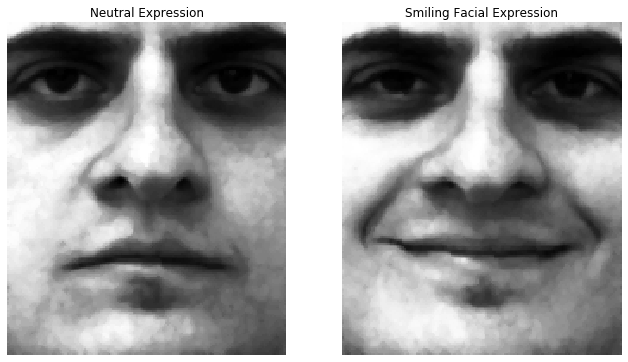

<Figure size 792x720 with 0 Axes>

In [17]:
# Visualize the first individual pictures from the dataset.
plt.subplot(1,2,1)
plt.imshow(X_neutral[0,:].reshape(original_size))
plt.axis('off')
plt.title('Neutral Expression')
plt.subplot(1,2,2)
plt.imshow(X_smile[0,:].reshape(original_size))
plt.axis('off')
plt.title('Smiling Facial Expression')

plt.show()
plt.savefig('image/image_show.jpg')

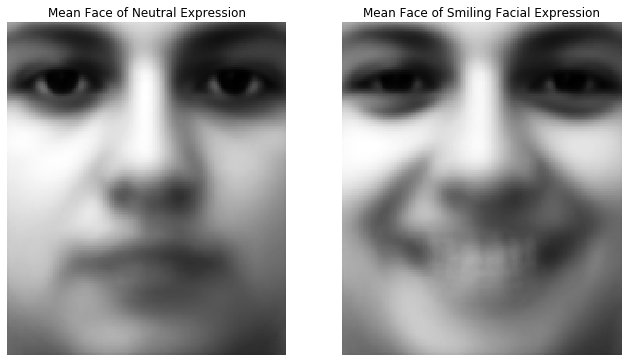

Randomly selected normalized images from neutral expression for visualization


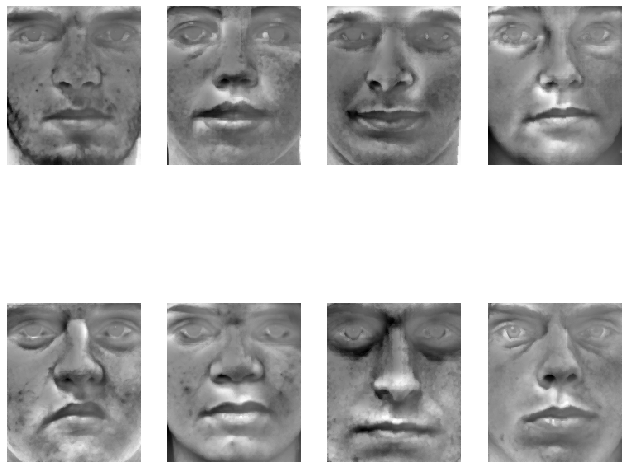

Randomly selected normalized images from smile expression for visualization


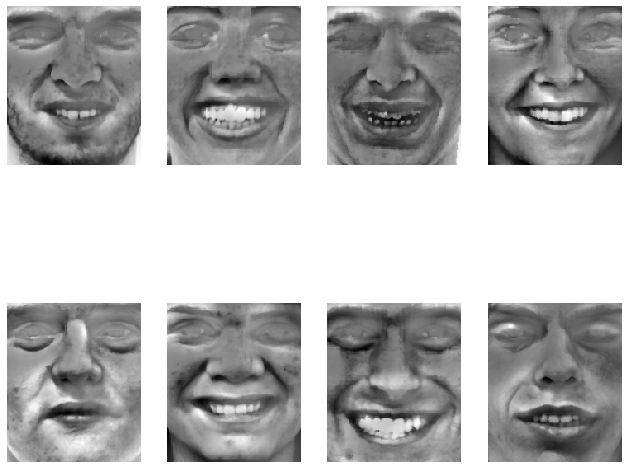

In [18]:
# Compute the mean face and normalize every images in training data
# For better computation performance, we will use broadcasting in numpy. If you don't know it, please refer to the following link:
# http://cs231n.github.io/python-numpy-tutorial/#numpy-broadcasting

# Compute the mean face
mean_neutral = np.mean(X_neutral, axis=0)
mean_smile = np.mean(X_smile, axis=0)
# Visualize the mean face
plt.subplot(1,2,1)
plt.imshow(mean_neutral.reshape(original_size))
plt.axis('off')
plt.title('Mean Face of Neutral Expression')
plt.subplot(1,2,2)
plt.imshow(mean_smile.reshape(original_size))
plt.axis('off')
plt.title('Mean Face of Smiling Facial Expression')
plt.show()
plt.savefig('image/meanface_show.jpg')

# Normalize the training data
X_neutral_nor = X_neutral - mean_neutral # shape of (200, 31266)
X_smile_nor = X_smile - mean_smile # shape of (200, 31266)
# Randomly select some images for visualization
idxs = np.random.choice(200, 8, replace=False)
print('Randomly selected normalized images from neutral expression for visualization')
for i,idx in enumerate(idxs):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_neutral_nor[idx,:].reshape(original_size))
    plt.axis('off')
plt.show()

print('Randomly selected normalized images from smile expression for visualization')
for i,idx in enumerate(idxs):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_smile_nor[idx,:].reshape(original_size))
    plt.axis('off')
plt.show()

In [19]:
# Compute eigenvectors and eigenvalues. The column v[:,i] is the eigenvector and each eigenvector is unitary.
evalue_neutral, evector_neutral = np.linalg.eig(np.dot(X_neutral_nor[range(0,190),:],X_neutral_nor[range(0,190),:].T))
evalue_smile, evector_smile = np.linalg.eig(np.dot(X_smile_nor[range(0,190),:],X_smile_nor[range(0,190),:].T))

# As usual, check and print out the size of the matrix.
print('Eigenvalues of neutral training data: ', evalue_neutral.shape)
print('Eigenvectors of neutral training data: ', evector_neutral.shape)
print('Eigenvalues of smile training data: ', evalue_smile.shape)
print('Eigenvectors of smile training data: ', evector_smile.shape)

# Sort eigenvalues and corresponding eigenvectors
idx = evalue_neutral.argsort()[::-1] 
evalue_neutral = evalue_neutral[idx]
evector_neutral = evector_neutral[:,idx]

idx = evalue_smile.argsort()[::-1] 
evalue_smile = evalue_smile[idx]
evector_smile = evector_smile[:,idx]

Eigenvalues of neutral training data:  (190,)
Eigenvectors of neutral training data:  (190, 190)
Eigenvalues of smile training data:  (190,)
Eigenvectors of smile training data:  (190, 190)


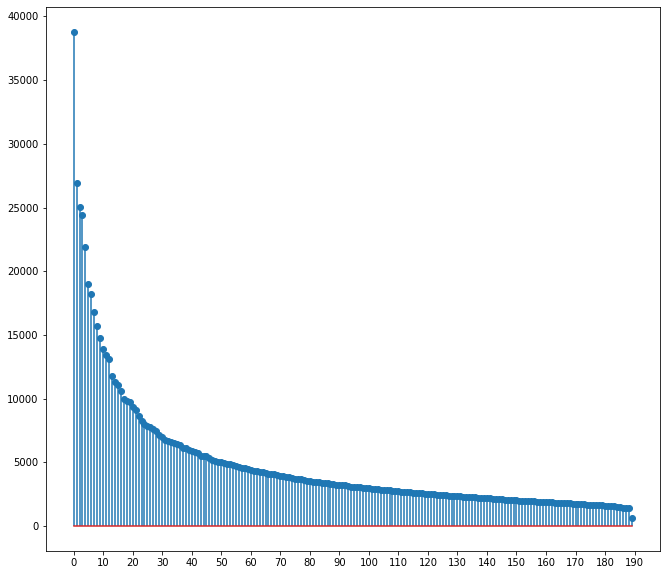

In [20]:
plt.stem(np.sqrt(evalue_neutral),use_line_collection=True)
my_x_ticks = np.arange(0, 191, 10)
plt.xticks(my_x_ticks)
plt.savefig('image/eigenvalues_neutral.jpg')
plt.show()

# plt.stem(evalue_smile,use_line_collection=True)
# plt.savefig('image/eigenvalues_smile.jpg')
# plt.show()

# #print(evalue_neutral)

In [21]:
# Compute eigenfaces
eigenface_neutral = np.dot(X_neutral_nor[range(0,190),:].T,evector_neutral)
eigenface_smile = np.dot(X_smile_nor[range(0,190),:].T,evector_smile)

# We should normalize the eigenfaces, making every eigenfaces to be unitary
eigenface_neutral = np.divide(eigenface_neutral , np.linalg.norm(eigenface_neutral , axis = 0))
eigenface_smile = np.divide(eigenface_smile , np.linalg.norm(eigenface_smile , axis = 0))

# Check and print the size of each eigenface. The column is the eigenface and each eigenface is unitary.
print('Single eigenface size: ', eigenface_neutral[:,0:1].shape)
# print(eigenface_neutral[:,0:1])
# PC = eigenface_neutral[:,0:20+1].T
# print(PC.shape)

Single eigenface size:  (31266, 1)


In [22]:
def MSE(ground_truth, reconst):
    """ This function is for compute the MSE """
    mse = ((ground_truth - reconst) ** 2).mean(axis = 0)
    return mse

def Reconstruct_MSE(num_PC, select_img, efaces, evalues):
    """ Reconstruct image and plot MSE vs different numbers of PC """
    PC = efaces[:,0:num_PC+1].T
    W =  np.dot(PC, select_img)
    reconst = np.dot(PC.T, W)
    # Compute the MSE
    mse = MSE(select_img, reconst)
    return mse

In [23]:
# Now we begin to reconstruct the training images using different numbers of PC. Compute the MSE and plot the curve vs number of PC.
# Randomly select 3 different images and reconstruct.

num_image_select = 3
idx = np.random.choice(range(0,190), num_image_select, replace=False)
select_img = X_neutral_nor[idx,:].T
print(idx)

[ 49  38 113]


In [219]:
# In this cell, I write in a naive way. It is not efficient but only for easy writing. It's better to try matrix way.
# Define 3 list to store MSE result
mse_1 = []
mse_2 = []
mse_3 = []
for num_PC in range(1,190):
    mse = Reconstruct_MSE(num_PC, select_img, eigenface_neutral, evalue_neutral)
    mse_1.append(mse[0])
    mse_2.append(mse[1])
    mse_3.append(mse[2])

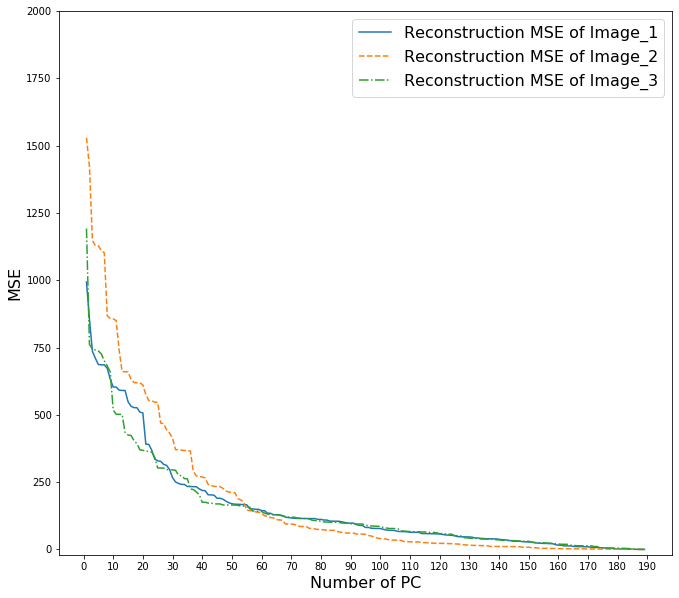

In [176]:
plt.plot(range(1,190), mse_1, linestyle='-', label="Reconstruction MSE of Image_1")
plt.plot(range(1,190), mse_2, linestyle='--', label="Reconstruction MSE of Image_2")
plt.plot(range(1,190), mse_3, linestyle='-.', label="Reconstruction MSE of Image_3")
plt.ylim(-20,2000)
plt.legend(loc="upper right", fontsize=16)
plt.ylabel("MSE", fontsize=16)
plt.xlabel("Number of PC", fontsize=16)
my_x_ticks = np.arange(0, 191, 10)
plt.xticks(my_x_ticks)
plt.savefig('image/mse_neutral.jpg')

In [179]:
# The same work as above but on smile training data
num_image_select = 3
idx = np.random.choice(range(0,190), num_image_select, replace=False)
select_img = X_smile_nor[idx,:].T

# Define 3 list to store MSE result
mse_1 = []
mse_2 = []
mse_3 = []
for num_PC in range(1,190):
    mse = Reconstruct_MSE(num_PC, select_img, eigenface_neutral, evalue_neutral)
    mse_1.append(mse[0])
    mse_2.append(mse[1])
    mse_3.append(mse[2])

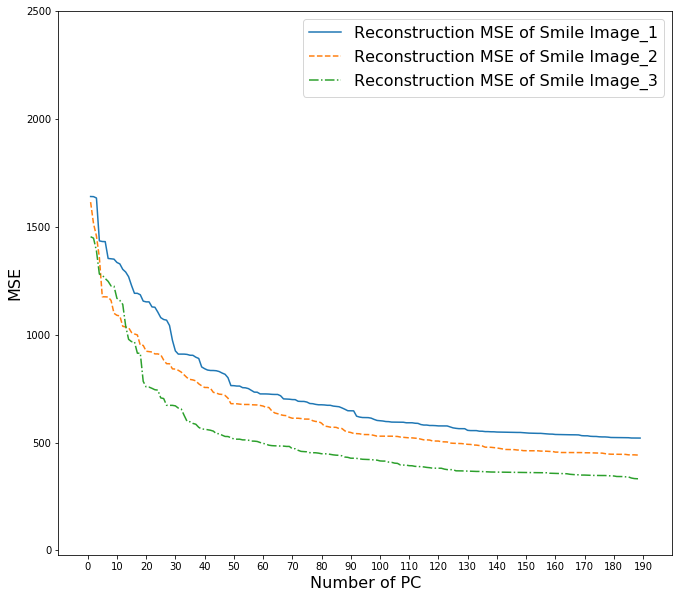

In [180]:
plt.plot(range(1,190), mse_1, linestyle='-', label="Reconstruction MSE of Smile Image_1")
plt.plot(range(1,190), mse_2, linestyle='--', label="Reconstruction MSE of Smile Image_2")
plt.plot(range(1,190), mse_3, linestyle='-.', label="Reconstruction MSE of Smile Image_3")
plt.ylim(-20,2500)
plt.xlim(-10,200)
plt.legend(loc="upper right", fontsize=16)
plt.ylabel("MSE", fontsize=16)
plt.xlabel("Number of PC", fontsize=16)
my_x_ticks = np.arange(0, 191, 10)
plt.xticks(my_x_ticks)
plt.savefig('image/mse_smile.jpg')

In [191]:
# Reconstrcut three of the other 10 individuals’ neutral expression image
num_image_select = 3
idx = np.random.choice(range(191,200), num_image_select, replace=False)
select_img = X_neutral_nor[idx,:].T
print(idx)

mse_1 = []
mse_2 = []
mse_3 = []
for num_PC in range(1,190):
    mse = Reconstruct_MSE(num_PC, select_img, eigenface_neutral, evalue_neutral)
    mse_1.append(mse[0])
    mse_2.append(mse[1])
    mse_3.append(mse[2])


[192 199 193]


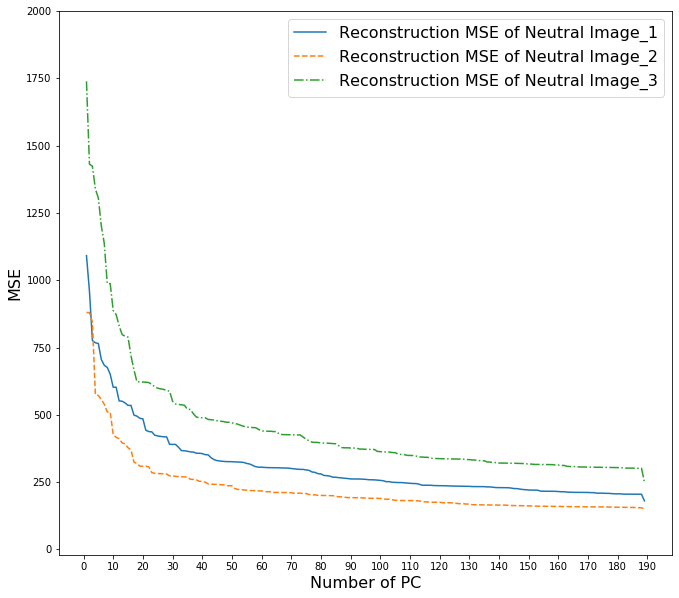

In [192]:
plt.plot(range(1,190), mse_1, linestyle='-', label="Reconstruction MSE of Neutral Image_1")
plt.plot(range(1,190), mse_2, linestyle='--', label="Reconstruction MSE of Neutral Image_2")
plt.plot(range(1,190), mse_3, linestyle='-.', label="Reconstruction MSE of Neutral Image_3")
plt.ylim(-20,2000)
plt.legend(loc="upper right", fontsize=16)
plt.ylabel("MSE", fontsize=16)
plt.xlabel("Number of PC", fontsize=16)
my_x_ticks = np.arange(0, 191, 10)
plt.xticks(my_x_ticks)
plt.savefig('image/mse_other_neutral.jpg')

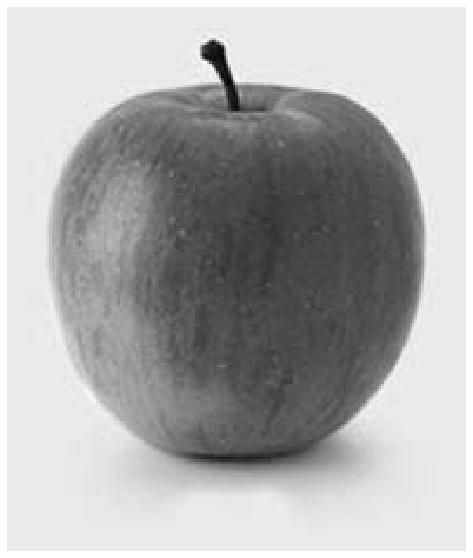

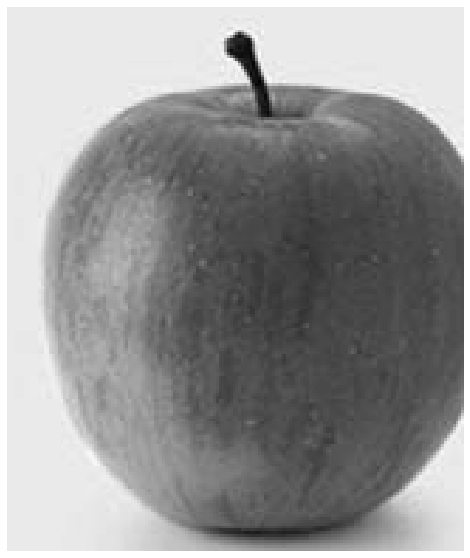

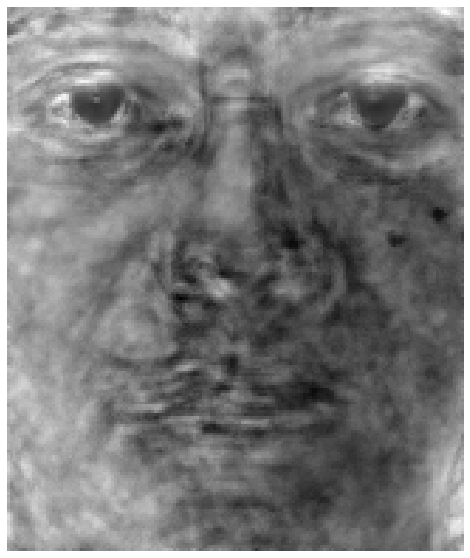

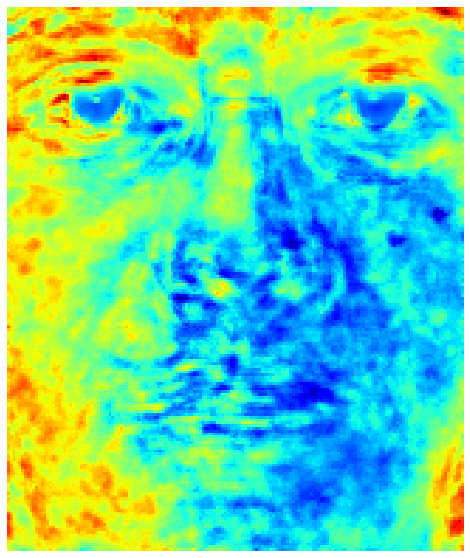

<Figure size 792x720 with 0 Axes>

In [24]:
# Read an apple image and try to reconstruct it
img_apple = plt.imread(dataset_path + 'apple1_gray.jpg')
# Show the apple image
plt.imshow(img_apple)
plt.axis('off')
plt.show()
# Show the cropped apple image
img_apple_crop = img_apple[5:198,5:167] #(5, 5, 166, 197)
plt.imshow(img_apple_crop)
plt.axis('off')
plt.show()
plt.savefig('image/apple_crop.jpg')
#print(img_apple_crop.shape)
W =  np.dot(eigenface_neutral.T, img_apple_crop.flatten()-mean_neutral)
reconst = np.dot(eigenface_neutral, W) + mean_neutral
plt.imshow(reconst.reshape(original_size))
plt.axis('off')
plt.show()
plt.savefig('image/apple_reconstruct.jpg')
plt.imshow(reconst.reshape(original_size),cmap='jet')
plt.axis('off')
plt.show()
plt.savefig('image/apple_reconstruct_jet.jpg')

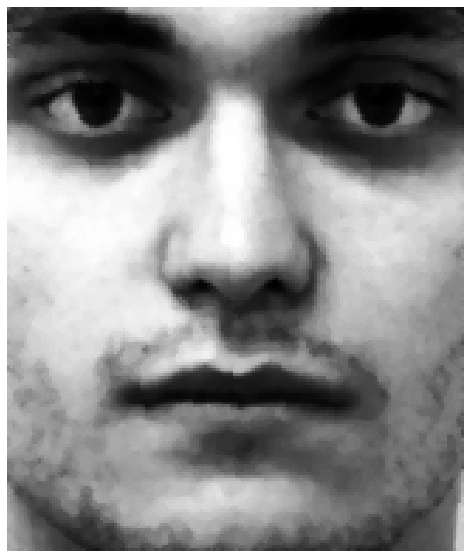

In [205]:
from PIL import Image
# Rotate one of 190 individuals’neutral expression image with different degrees and try to reconstruct it using all PCs
# num_image_select = 1
# idx = np.random.choice(range(0,190), num_image_select, replace=False)
idx = 73 # Select one of the image
filepath = os.path.join(dataset_path, 'Part_%d' % (1, ))
select_img = Image.open(filepath + '/%da.jpg' % (idx, ))
plt.imshow(select_img)
plt.axis('off')
plt.savefig('image/select_image.jpg')

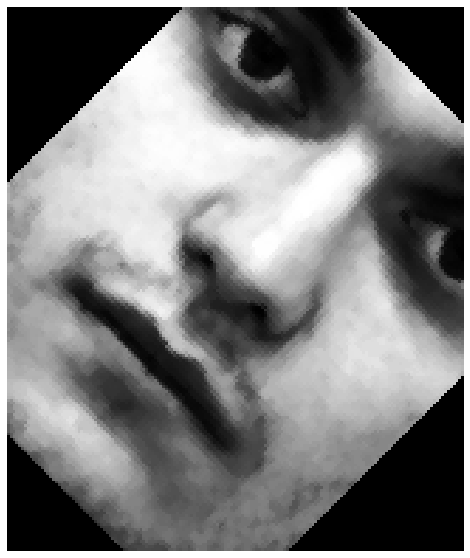

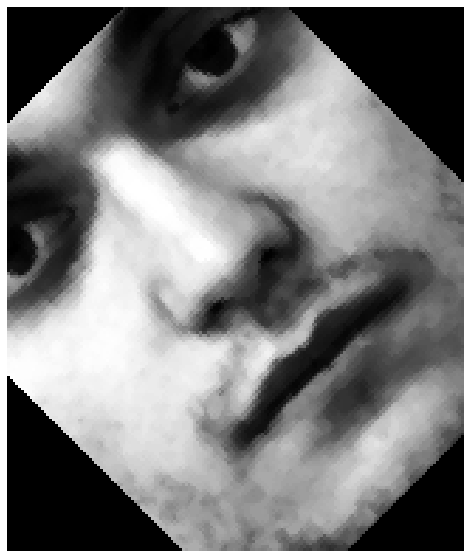

<Figure size 792x720 with 0 Axes>

In [206]:
rotated = select_img.rotate(-45)
plt.imshow(rotated)
plt.axis('off')
plt.show()
plt.savefig('image/select_image_rotate-45.jpg')
rotated = select_img.rotate(45)
plt.imshow(rotated)
plt.axis('off')
plt.show()
plt.savefig('image/select_image_rotate45.jpg')

In [207]:
mse_rotate = []
for degree in range(-90,91):
    rotate_img = select_img.rotate(degree)
    W =  np.dot(eigenface_neutral.T, np.array(rotate_img).flatten()-mean_neutral)
    reconst = np.dot(eigenface_neutral, W)
    mse = MSE(np.array(rotate_img).flatten()-mean_neutral, reconst)
    mse_rotate.append(mse)

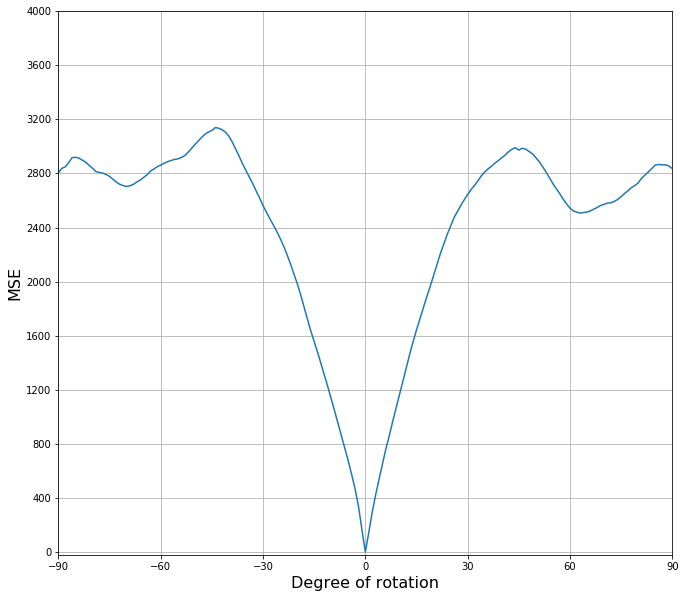

In [209]:
plt.plot(range(-90,91), mse_rotate, linestyle='-')
plt.ylim(-20,4000)
plt.xlim((-90,90))
my_x_ticks = np.arange(-90, 91, 30)
plt.xticks(my_x_ticks)
my_y_ticks = np.arange(0, 4001, 400)
plt.yticks(my_y_ticks)
plt.ylabel("MSE", fontsize=16)
plt.xlabel("Degree of rotation", fontsize=16)
plt.grid(True)
plt.savefig('image/mse_rotate.jpg')